In [79]:
import pandas as pd
from collections import Counter
import ast
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# Import data
data = pd.read_csv("data/filtered_movie_data.csv")
df = pd.DataFrame(data)

In [81]:
# Useful General Functions

#Plot naming and showing
def name_plot(ylabel, title):
    plt.xticks(rotation=90)
    plt.ylabel(ylabel)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(title)
    plt.show()
    plt.close()

In [82]:
# Functions for calculations

def count_genre_over_years(dataframe, genre):
    dataframe['Genres'] = dataframe['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    genre_counts_by_year = (
        dataframe[dataframe['Genres'].apply(lambda genres: genre in genres)]
        .groupby('Year')
        .size()
        .reset_index(name='Count')
    )
    return genre_counts_by_year

def top_years_for_genre(genre_counts_by_year, top_n=20):
    top_years_chronological = genre_counts_by_year.nlargest(top_n, 'Count')
    return top_years_chronological

# Function to count genres for a specific year and return total movies
def count_genres_by_year(dataframe, year):
    filtered_df = dataframe[dataframe['Year'] == year].copy()
    filtered_df.loc[:, 'Genres'] = filtered_df['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    all_genres = [genre for genres in filtered_df['Genres'] for genre in genres]
    genre_counts = Counter(all_genres)
    genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False).reset_index(drop=True)
    return genre_counts_df, len(all_genres)

# Function to calculate the difference in genre counts between two years
def calc_genre_differences(counts_year1, counts_year2, year1, year2):
    merged_counts = pd.merge(counts_year1, counts_year2, on='Genre', how='outer', suffixes=(f'_{year1}', f'_{year2}')).fillna(0)
    merged_counts['Difference'] = merged_counts[f'Count_{year1}'] - merged_counts[f'Count_{year2}']
    merged_counts = merged_counts.sort_values(by='Difference', ascending=False).reset_index(drop=True)
    return merged_counts

# Function to calculate relative genre growth
def calc_genre_growth(counts_year1, counts_year2, year1, year2):
    merged_counts = pd.merge(counts_year1, counts_year2, on='Genre', how='outer', suffixes=(f'_{year1}', f'_{year2}')).fillna(0)
    merged_counts['Difference'] = merged_counts[f'Count_{year2}'] - merged_counts[f'Count_{year1}']
    merged_counts['Percentage_Increase'] = merged_counts.apply(
        lambda row: (row['Difference'] / row[f'Count_{year1}']) * 100 if row[f'Count_{year1}'] > 0 else float('inf'),
        axis=1
    )
    merged_counts = merged_counts.sort_values(by='Percentage_Increase', ascending=False).reset_index(drop=True)
    return merged_counts

# Function to calculate proportional difference of genres between two years
def calc_relative_growth(counts_year1, counts_year2, year1, year2, total_movies_year1, total_movies_year2):
    # Add proportions relative to the total number of movies for each year
    counts_year1['Proportion'] = counts_year1['Count'] / total_movies_year1
    counts_year2['Proportion'] = counts_year2['Count'] / total_movies_year2
    
    # Merge and keep the suffixes to distinguish each year's proportions
    merged_counts = pd.merge(counts_year1, counts_year2, on='Genre', how='outer', suffixes=(f'_{year1}', f'_{year2}')).fillna(0)
    merged_counts[f'Proportion_Difference'] = merged_counts[f'Proportion_{year2}'] - merged_counts[f'Proportion_{year1}']
    
    return merged_counts.sort_values(by='Proportion_Difference', ascending=False).reset_index(drop=True)

Here I would like to explore the genres released throughout the Vietnam War. The war lasted from 1959 to 1975, so I have chosen to comapre those years with the middle of the war - 1967. First, I calculate the 30 most popular genres during each year.

Genre Counts:


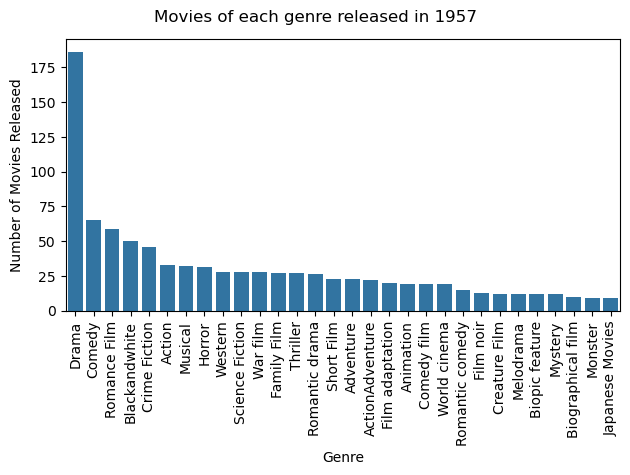

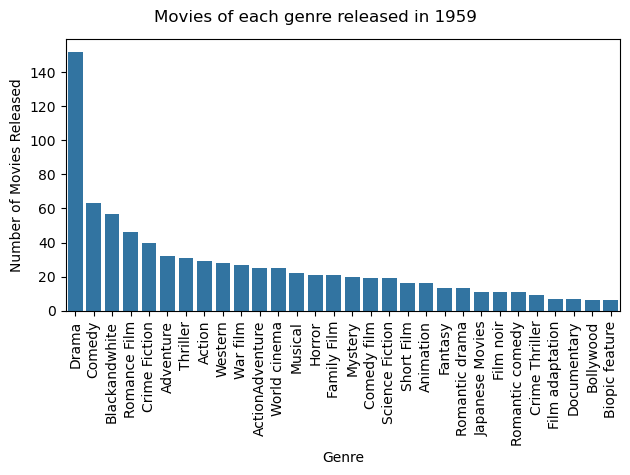

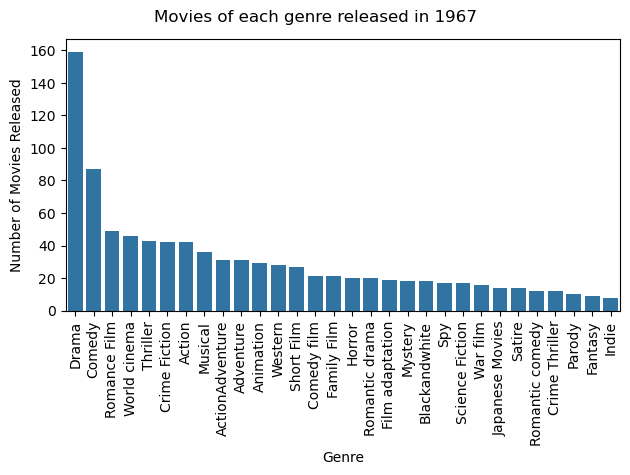

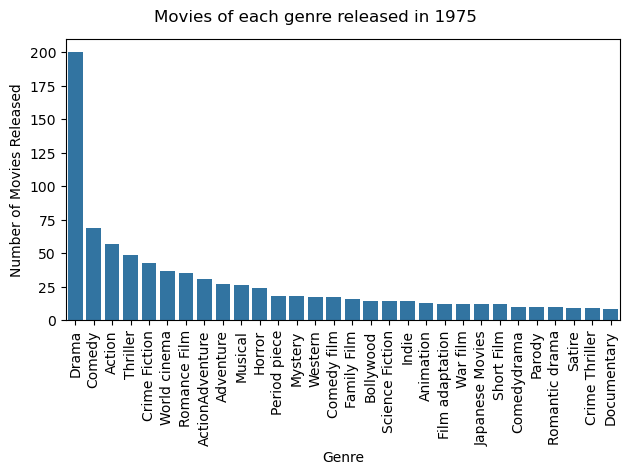

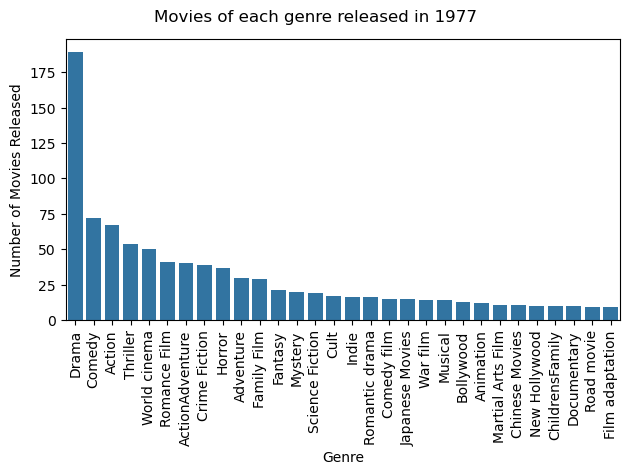

In [83]:
# Initialize years and datafraes for genre counts for each
year0, year1, year2, year3, year4 = 1957, 1959, 1967, 1975, 1977

counts_year0, total_movies_year0 = count_genres_by_year(df, year0)
counts_year1, total_movies_year1 = count_genres_by_year(df, year1)
counts_year2, total_movies_year2 = count_genres_by_year(df, year2)
counts_year3, total_movies_year3 = count_genres_by_year(df, year3)
counts_year4, total_movies_year4 = count_genres_by_year(df, year4)

# Calculating genre differences
print("Genre Counts:")
VW_0_genres = count_genres_by_year(df, year0)[0].head(30)
VW_1_genres = count_genres_by_year(df, year1)[0].head(30)
VW_2_genres = count_genres_by_year(df, year2)[0].head(30)
VW_3_genres = count_genres_by_year(df, year3)[0].head(30)
VW_4_genres = count_genres_by_year(df, year4)[0].head(30)

sns.barplot(data = VW_0_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1957")
sns.barplot(data = VW_1_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1959")
sns.barplot(data = VW_2_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1967")
sns.barplot(data = VW_3_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1975")
sns.barplot(data = VW_4_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1977")

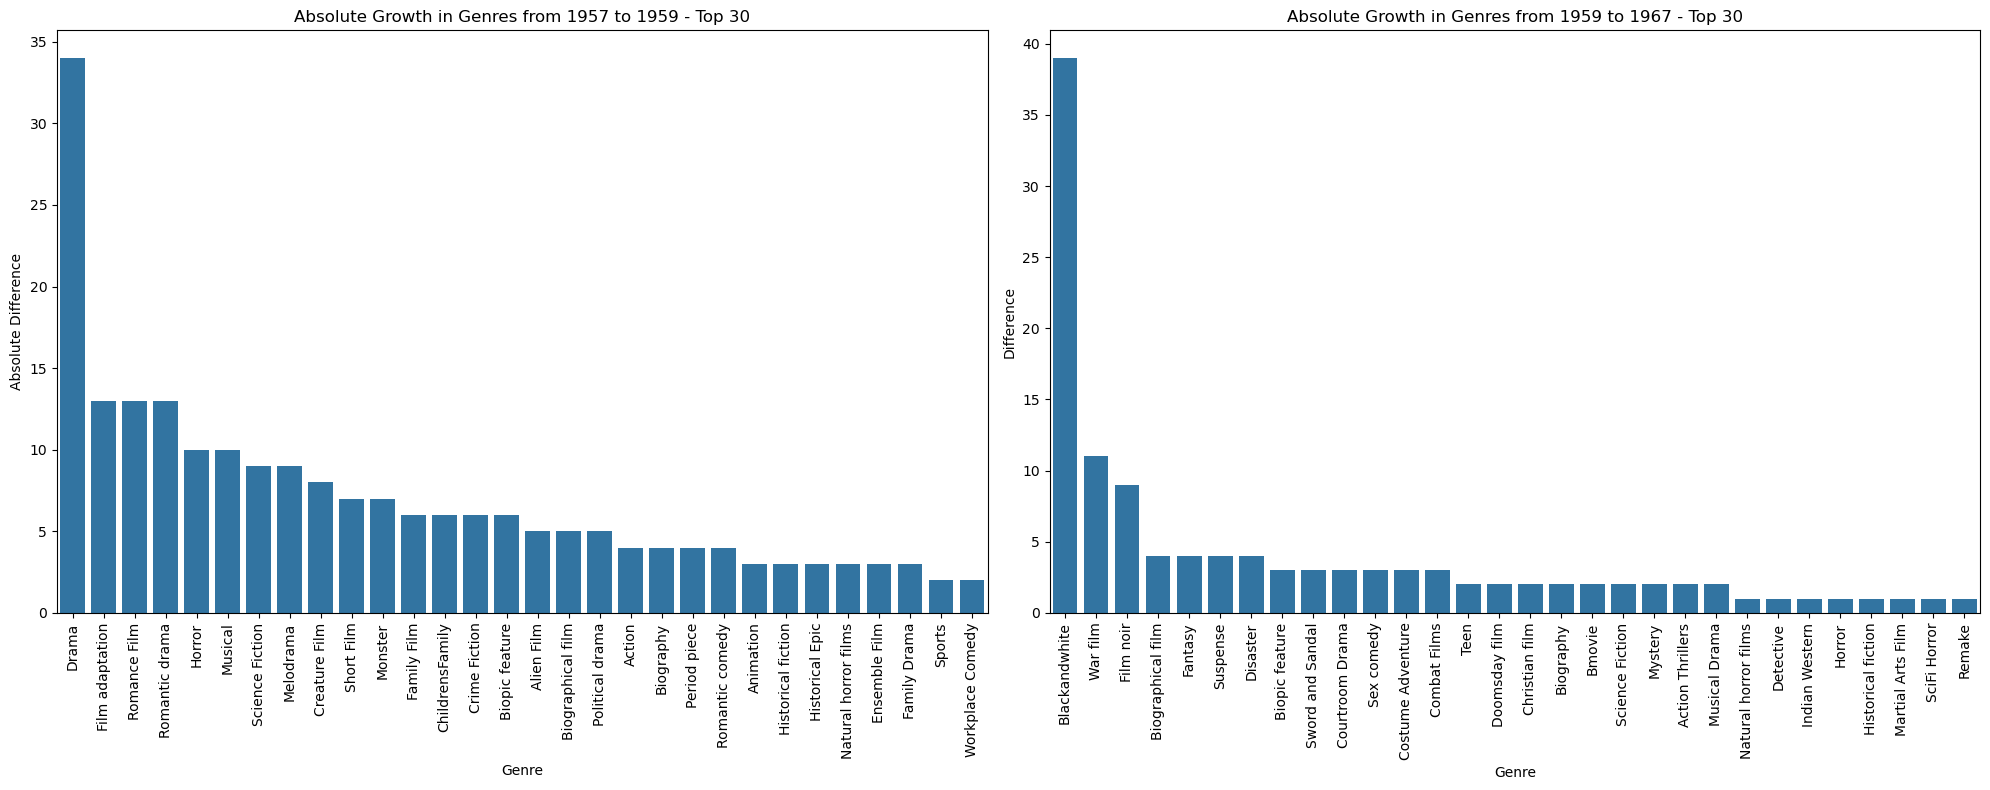

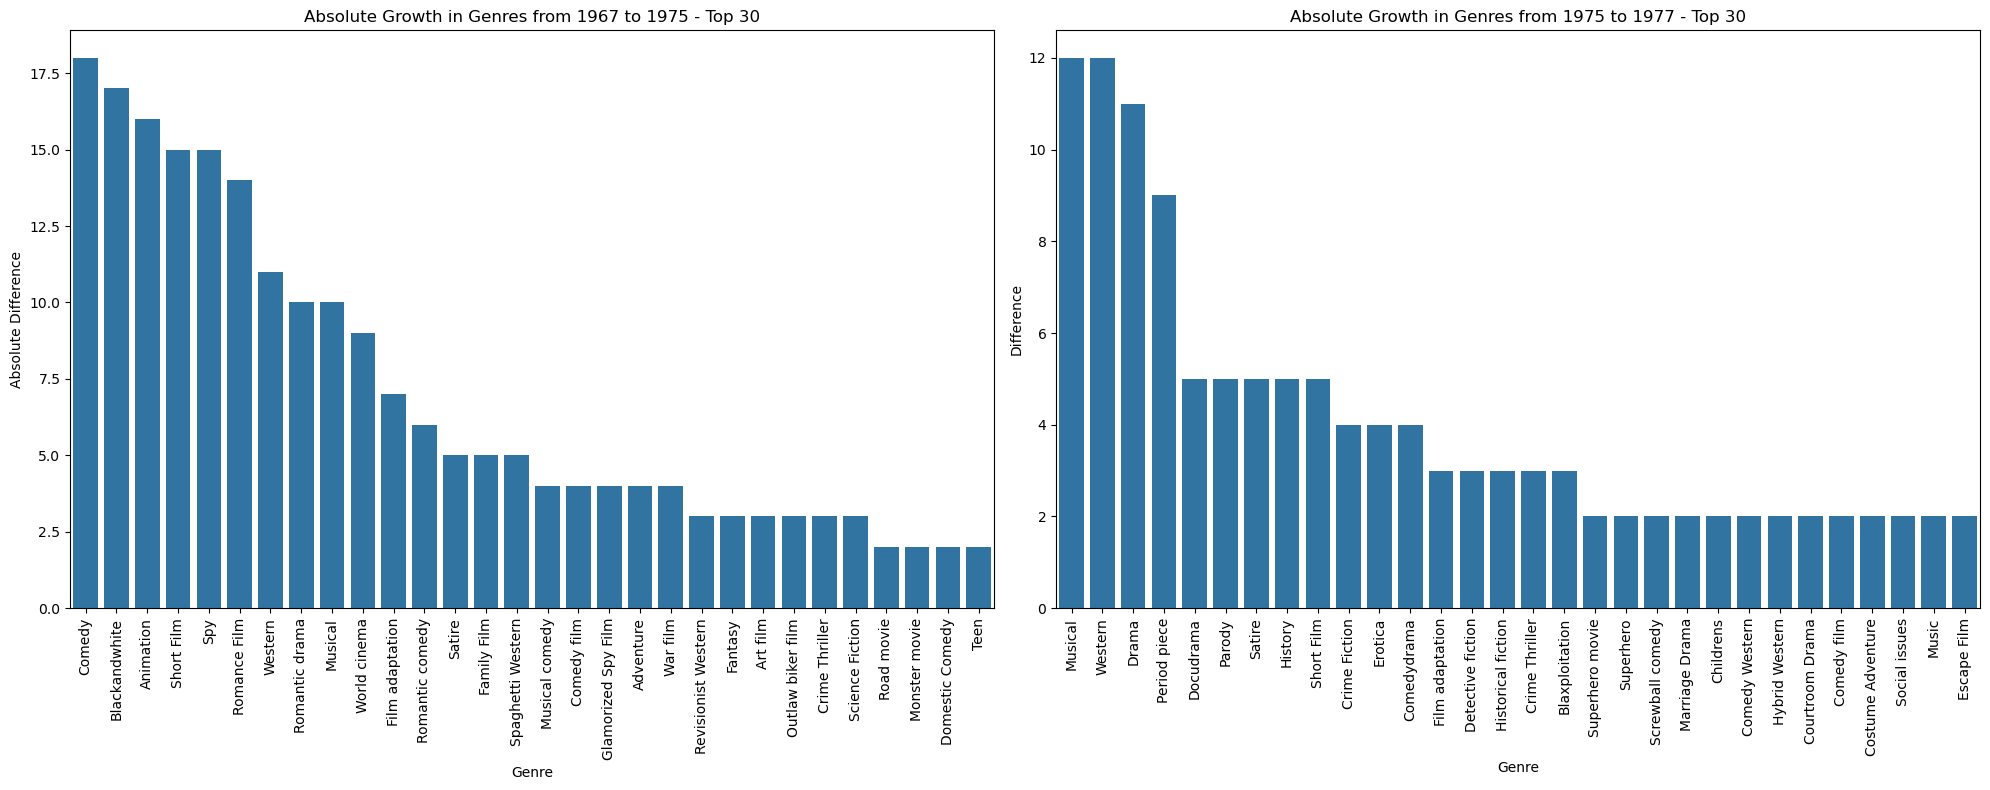

In [84]:
abs_difference_year0_year1 = calc_genre_differences(counts_year0, counts_year1, year0, year1)
abs_difference_year1_year2 = calc_genre_differences(counts_year1, counts_year2, year1, year2)
abs_difference_year2_year3 = calc_genre_differences(counts_year2, counts_year3, year2, year3)
abs_difference_year3_year4 = calc_genre_differences(counts_year3, counts_year4, year3, year4)

# Create subplots with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# First plot: Absolute difference for year1 and year2
sns.barplot(data=abs_difference_year0_year1.head(30), x="Genre", y="Difference", ax=axes[0])
axes[0].set_title(f"Absolute Growth in Genres from {year0} to {year1} - Top 30")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Second plot: Absolute difference for year2 and year3
sns.barplot(data=abs_difference_year1_year2.head(30), x="Genre", y="Difference", ax=axes[1])
axes[1].set_title(f"Absolute Growth in Genres from {year1} to {year2} - Top 30")
axes[1].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Adjust layout to prevent overlap and ensure both plots fit within the figure
plt.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# First plot: Absolute difference for year1 and year2
sns.barplot(data=abs_difference_year2_year3.head(30), x="Genre", y="Difference", ax=axes[0])
axes[0].set_title(f"Absolute Growth in Genres from {year2} to {year3} - Top 30")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Second plot: Absolute difference for year2 and year3
sns.barplot(data=abs_difference_year3_year4.head(30), x="Genre", y="Difference", ax=axes[1])
axes[1].set_title(f"Absolute Growth in Genres from {year3} to {year4} - Top 30")
axes[1].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Adjust layout to prevent overlap and ensure both plots fit within the figure
plt.tight_layout()
plt.show()
plt.close()